# Nowcasting India GDP Using Dynamic Factor Model

Author: S S K Pavan

Roll No: 2020HES7045

Dynamic factor models postulate that a small number of unobserved "factors" can be used to explain a substantial portion of the variation and dynamics in a larger number of observed variables. This notebook replicates the 2021 research paper titled "[Constructing a Coincident Economic Indicator for India: How Well Does It Track Gross Domestic Product?](https://www.worldscientific.com/doi/pdf/10.1142/S0116110521500104)" by Bhadury et. al 

In [230]:
# imports
%matplotlib inline

import types
import numpy as np
import pandas as pd
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.iolib.summary2 import summary_col
from statsmodels.tools.eval_measures import rmse

# for stationarity transformations
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose

import matplotlib.pyplot as plt
import seaborn as sns

In the iterauture Dynamic factor models are estimated using several hundered variables. This paper takes a different approach and custom selects the variables that enter the model. The authors consider two criteria:
- High correlation with Indian GDP
- Best predictor of turining points in India GDP growth selected using LASSO regression. 
In this notebook we are going to skip the variable selection and directly jump into the dynamic factor analysis using the variables that the paper has found to be salinet. The following are the listed variables classified into three sets on which seperate models will be run:

|Variable            |CEII-6  |CEII-9  |CEII-12|
|--------------------|--------|--------|-------|
|Air cargo           |[x]     |[x]     |[x]    |
|Auto total          |[x]     |[x]     |[x]    |
|Government receipts |[x]     |[x]     |[x]    |
|IIP consumer goods  |[x]     |[x]     |[x]    |
|IIP core            |[x]     |[x]     |[x]    |
|electricity generated|[x]     |[x]     |[x]    |
|Exports             |        |[x]     |[x]    |
|Foreign tourist     |        |[x]     |[x]    |
|NONG imports        |        |[x]     |[x]    |
|NEER                |        |        |[x]    |
|Bank credit         |        |        |[x]    |
|Sensex              |        |        |[x]    |
- CEII-6 model covers exclusively domestic economic activity indicators
- CEII-9 model incorporates trade and the service sector
- CEII-12 model incorporates financial variables <br>
Due to issue with availabiity of data In this analysis we will use electricity generation data instead of rail frieght data which was used by the reaserch paper. <br> 
Using the above three sets of variabiles, we estimate three indexes representing the common trend underlying these variables.

## Loading the Variables and cleaning the data

In [66]:
# read variables data
raw_var = pd.read_excel("./data/raw_data_final.xlsx", sheet_name="all_variable_data", index_col=0)

#read GDP data
raw_gdp = pd.read_excel("./data/raw_data_final.xlsx", sheet_name="splice", 
                            header= 2, index_col= 0, 
                            usecols="A:D")

In [67]:
# reset index to datetime
raw_var.index = pd.Series(pd.date_range("4/1/2004", freq="M", periods=(18*12)-6))
raw_gdp.index = pd.Series(pd.date_range("6/1/2004", freq="Q", periods=(18*4)-3))
# Declare the frequency
raw_gdp.index.freq = "Q"
raw_var.index.freq = "M"

## Stationarity

|Variable   |Method   |
|-----------|---------|
|IIP Core   |Seasonial decomposition|
|IIP consumer| first difference |
|Air cargo| first difference |
|Auto| first difference |
|electricity   |Seasonial decomposition|
|govt receipts | log double difference |
| exports |  log difference |
| imports |  log difference |
|tourist | double diff |
|neer | Double difference|
|sensex| Double difference|
| bank credit | double difference |

The Stationarity of the transformations has been checked by running the Dickey-Fuller test




In [68]:
# log double diff and first difference method:
raw_var["iip_core_st"] = np.log(raw_var.iip_core).diff().diff()
raw_var["iip_cons_st"] = raw_var.iip_cons.diff()
raw_var["air_cargo_st"] = raw_var.air_cargo.diff()
raw_var["auto_st"] = raw_var.auto.diff()
raw_var["electricity_st"] = np.log(raw_var.electricity).diff().diff()
# log double difference:
raw_var["govt_receipt_st"] = np.log(raw_var.govt_receipt).diff().diff()
# log difference
raw_var["exports_st"] = np.log(raw_var.exports).diff()
raw_var["imports_st"] = np.log(raw_var.imports).diff()
# double differences
raw_var["tourist_st"] = raw_var.tourist.diff().diff()
raw_var["neer_st"] = raw_var.neer.diff().diff()
raw_var["sensex_st"] = raw_var.sensex.diff().diff()
raw_var["bank_credit_st"] = raw_var.bank_credit.diff().diff()

Check the p-values values for the dickey fuller test to seeif any of the variables are stationary 

In [69]:
# dickey fuller test
def dickey_fuller():
    for col in raw_var.columns[-12:]:
        dftest = adfuller(raw_var[f"{col}"].dropna(), autolag = 'AIC')
        
        yield {
            "variable": col,
            "DF p-val": dftest[1]
        }
        
df_data = pd.DataFrame(dickey_fuller())
df_data


,variable,DF p-val
0,iip_core_st,6.971751e-12
1,iip_cons_st,3.805619e-07
2,air_cargo_st,7.836489e-04
3,auto_st,8.823812e-05
4,electricity_st,3.220542e-13
5,govt_receipt_st,9.422986e-24
6,exports_st,1.414960e-04
7,imports_st,0.000000e+00
8,tourist_st,6.057234e-09
9,neer_st,1.695849e-04


Text(0.5, 1.0, 'log diff')

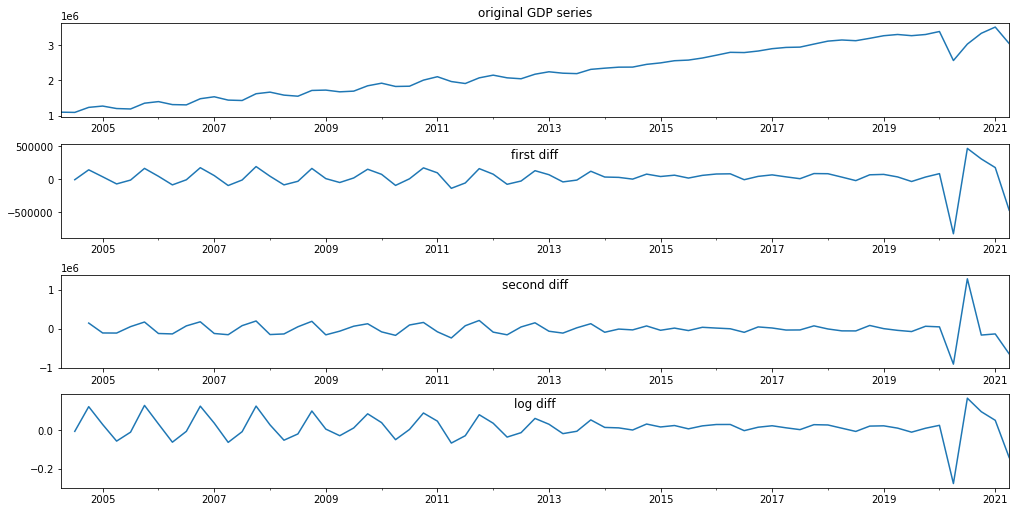

In [70]:
# stationarity of GDP series
fig, ax = plt.subplots(4,figsize=(14,7), constrained_layout=True)
raw_gdp.spliced.plot(ax=ax[0])
ax[0].set_title("original GDP series")

raw_gdp.spliced.diff().plot(ax=ax[1])
ax[1].set_title("first diff", y=1.0, pad=-14)

raw_gdp.spliced.diff().diff().plot(ax=ax[2])
ax[2].set_title("second diff", y=1.0, pad=-14)

np.log(raw_gdp.spliced).diff().plot(ax=ax[3])
ax[3].set_title("log diff", y=1.0, pad=-14)

In [71]:
# creating a new dataframe for all the stationary variables
clean_var = raw_var.iloc[:,-12:]
clean_var.head()

,iip_core_st,iip_cons_st,air_cargo_st,auto_st,electricity_st,govt_receipt_st,exports_st,imports_st,tourist_st,neer_st,sensex_st,bank_credit_st
2004-04-30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2004-05-31,NaN,NaN,1842.0,248.313817,NaN,NaN,0.084726,0.270897,NaN,NaN,NaN,NaN
2004-06-30,-0.044327,NaN,4128.0,3539.429542,-0.010263,-0.908789,0.023116,0.017495,76002.0,1.7480,931.31,16118.4000
2004-07-31,0.063708,NaN,3086.0,5728.000437,0.106559,-0.928347,-0.030257,-0.055947,11714.0,-0.3061,339.02,-4243.8198
2004-08-31,-0.066450,NaN,1611.0,-6078.085366,-0.116429,-0.048596,0.034305,0.007687,-68489.0,1.9937,-353.10,7657.5366


## Dynamic Factor Model

### General Model specification

Now we need to specify all the details of the specific dynamic factor model that we want to estimate. In particular, we will choose:

1. Factor specification, including: how many factors to include, which variables load on which factors, and the order of the (vector) autoregression that the factor evolves according to.

2. Whether or not to standardize the dataset for estimation.

3. Whether to model the idiosyncratic error terms as AR(1) processes or as iid.

### Our Specific Model

$$
\begin{align*}
            Y_t = \Lambda f_t + E_t, \;\;\;\;\; E_t~\;\;i.i.d \; N(0, R)\\
            f_t = \beta f_{t-1} + u_t, \;\;\;\;\; u_t~\;\;i.i.d \; N(0, q)
\end{align*}
$$
1. $Y_t$ contains only monthly indicators from a balanced panel
2. $\Lambda$ is the matrix of factor loadings
3. We are going to estmate only one factor $f_t$, which has a VAR(1) specification and loads on all the variables
4. $u_t$ is the error term which is modelled as iid

### Factor specification
In the `DynamicFactorMQ` model, the basic factor structure is specified using the `factors` argument, which must be one of the following:

- An integer, which can be used if one wants to specify only that number of global factors. This only allows a very simple factor specification.
- A dictionary with keys equal to observed variable names and values equal to a list of factor names. Note that if this approach is used, the all observed variables must be included in this dictionary.

There are number of ways to identify how many factors to use. We will go ahead with the simple speicfication of using the integer method as we have only one factor. 

**Creating the model**
Now that we have a simple factor specification, let us discuss the primary arguments in the `DynamicFactorMQ` model class

1. `endog` and `endog_quarterly`

   These arguments are used to pass the observed variables to the model. There are two ways to provide the data:
   
   1. Since we want to first create a factor and the run a regression to forecast GDP, we will pass all of your observed montly variables to the `endog` variable and not include the `endog_quarterly` argument. Note here that we are not passing the quarterly GDP series into the model. 

2. `factors`, `factor_orders`, and `factor_multiplicities`

   Factors = 1, factor_orders is the lag order of the factor VAR. We set it to 1. Since we have only one factor, the factor_multiplicities defaults to 1

3. `idiosyncratic_ar1`

   The `DynamicFactorMQ` model allows the idiosyncratic disturbance terms to be modeled as independent AR(1) processes or as iid variables. The default is `idiosyncratic_ar1=True`. We set it to false. Setting it to True can help in modeling some of the idiosyncratic serial correlation for forecasting.



In [72]:
# Construct the dynamic factor model
model = sm.tsa.DynamicFactorMQ(
                                endog = clean_var.iloc,
                                factors= 1, 
                                factor_orders= 1,
                                factor_multiplicities= 1,
                                idiosyncratic_ar1=False 
                        )

In [73]:
# check our specifications before fitting the model
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                         Model Specification: Dynamic Factor Model                         
===========================================================================================
Model:                Dynamic Factor Model   # of observed variables:                    11
                   + 1 factors in 1 blocks   # of factors:                                1
                       + iid idiosyncratic   Idiosyncratic disturbances:                iid
Sample:                2004-04-30 00:00:00   Standardize variables:                    True
                     - 2021-09-30 00:00:00                                                 
Observed variables / factor loadings
==========================
  Dep. variable          0
--------------------------
    iip_cons_st          X
   air_cargo_st          X
        auto_st          X
 electricity_st          X
govt_receipt_st          X
     exports_st          X
     imports_st          X
     tourist_st          X
        neer_st          X
      sensex_st          X
 bank_credit_st          X
    Factor blocks:   
=====================
     block      order
---------------------
         0          1
=====================
"""

### Model fitting / parameter estimation

We fit the model using the `fit` method. This method does not affect the `model` object that we created before, but instead returns a new `results` object that contains the estimates of the parameters and the state vector, and also allows forecasting and computation of the "news" when updated data arrives.

The default method for parameter estimation in the `DynamicFactorMQ` class is maximum likelihood via the EM algorithm.

Using the `disp=10` method we can print details of every 10th iteration of the EM algorithm, to track its progress.

In [74]:
results = model.fit(disp=10)

EM start iterations, llf=-2902.9
EM iteration 10, llf=-2849.4, convergence criterion=4.4966e-06
EM converged at iteration 16, llf=-2849.4, convergence criterion=9.9287e-07 < tolerance=1e-06


In [75]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                Dynamic Factor Results                                
======================================================================================
Dep. Variable:     "iip_cons_st", and 10 more   No. Observations:                  210
Model:                   Dynamic Factor Model   Log Likelihood               -2849.361
                      + 1 factors in 1 blocks   AIC                           5746.723
                          + iid idiosyncratic   BIC                           5827.054
Date:                        Mon, 29 Nov 2021   HQIC                          5779.198
Time:                                03:56:10   EM Iterations                       16
Sample:                            04-30-2004                                         
                                 - 09-30-2021                                         
Covariance Type:                 Not computed                                         
        Observation equation:         
======================================
Factor loadings:          0       var.
--------------------------------------
     iip_cons_st      -0.39       0.36
    air_cargo_st      -0.41       0.30
         auto_st      -0.15       0.93
  electricity_st      -0.31       0.59
 govt_receipt_st      -0.23       0.75
      exports_st      -0.43       0.25
      imports_st      -0.31       0.61
      tourist_st      -0.04       0.99
         neer_st       0.01       0.99
       sensex_st       0.12       0.93
  bank_credit_st      -0.22       0.79
       Transition: Factor block 0      
=======================================
                 L1.0    error variance
---------------------------------------
         0      -0.39              3.45
=======================================

Warnings:
[1] Covariance matrix not calculated.
"""

The ovservation equation tabble gives the factor loadings on each of the factors and its variance . We can see that the common factor is negetively related to autombile registrations, sensex and Nominal effective exchange rate

### Estimated factors
The `results` object contains the estimates of the latent factorswhich can be accessed through the `factors` attribute. This attribute four sub-attributes:
- `smoothed`: estimates of the factors, conditional on the full dataset (also called "smoothed" or "two-sided" estimates)
- `smoothed_cov`: covariance matrix of the factor estimates, conditional on the full dataset
- `filtered`: estimates of the factors, where the estimate at time $t$ only uses information through time $t$ (also called "filtered" or "one-sided" estimates
- `filtered_cov`: covariance matrix of the factor estimates, where the estimate at time $t$ only uses information through time $t$


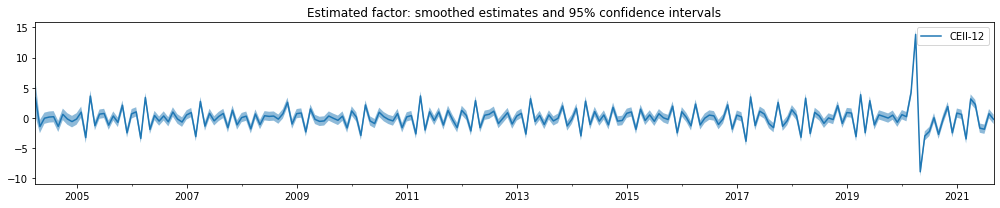

In [76]:
# get factors conditional on the full dataset
mean = results.factors.smoothed
mean  = mean.rename(columns = {"0": "CEII-12"})

# Compute 95% confidence intervals
from scipy.stats import norm
# reset cov matrix index so that CI can be calculated
std = results.factors.smoothed_cov.reset_index(level=[0])
# critical value
crit = norm.ppf(1 - 0.05 / 2)
lower = mean["CEII-12"] - crit * std["0"]
upper = mean["CEII-12"] + crit * std["0"]


fig, ax = plt.subplots(figsize=(14, 3))
mean.plot(ax=ax, label = "CEII-12")

ax.fill_between(mean.index, lower, upper, alpha=0.5)
# ax.set_label("CEII-12")
ax.set_title('Estimated factor: smoothed estimates and 95% confidence intervals')
fig.tight_layout()

This is the plot of the estimated factor from all of the variables. Clearly there seems to be some seasonality to the estimated factor.

Now we calculate the factor for the smaller number of variables

#### Explanatory power of the factors

We examine how the factors relate to the observed variables by computing the explanatory power that the factor has for each variable. This is done by regressing each variable on a constant plus the smoothed factor estimates and storing the resulting $R^2$, or "coefficient of determination", value.

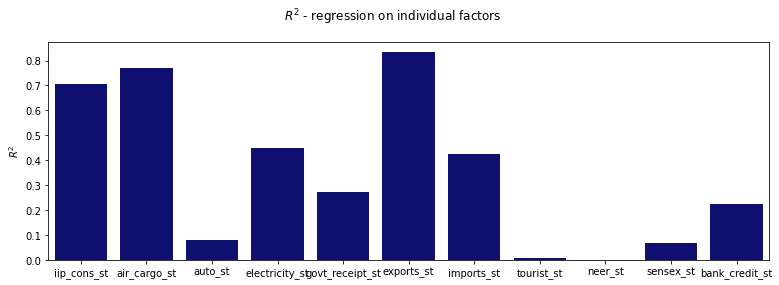

In [112]:
# get the explanatory power of the factor on each variable
rsquared = results.get_coefficients_of_determination(method='individual')
# plotting the R^2
fig, ax = plt.subplots(figsize=(11,4))
sns.barplot(x=rsquared.index, y="0", data=rsquared, color="navy")
ax.set_ylabel(r'$R^2$')
fig.suptitle(r'$R^2$ - regression on individual factors')
fig.tight_layout()

In [80]:
# seperating out the different sets of variables
ceii_6 = clean_var.iloc[:, :6]
ceii_9 = clean_var.iloc[:, :9]

In [81]:
# defining a function which does all of the above steps:
# I have added an extra argument which allows us to include quarterly gdp also in the model
# Argument ma asks to plot the moving average of the change in factor or not. Default False plots original factor
def dfm(set, name , exog_q = "N", ma = False):
        if type(exog_q) == str:
                m = None
        else:
                m = exog_q 
        model = sm.tsa.DynamicFactorMQ(
                                endog = set,
                                endog_quarterly = m, 
                                factors= 1, 
                                factor_orders= 1,
                                factor_multiplicities= 1,
                                idiosyncratic_ar1=False 
                        )
        results = model.fit()
        # get factors conditional on the full dataset
        mean = results.factors.smoothed
        mean  = mean.rename(columns = {"0": name})

        # Compute 95% confidence intervals
        from scipy.stats import norm
        # reset cov matrix index so that CI can be calculated
        std = results.factors.smoothed_cov.reset_index(level=[0])
        # critical value
        crit = norm.ppf(1 - 0.05 / 2)
        lower = mean[name] - crit * std["0"]
        upper = mean[name] + crit * std["0"]
        

        # calculating month-on month and yr-on-yr change
        M_oM =  mean[name].pct_change(periods = 1)
        Y_oY =  mean[name].pct_change(periods = 12)
        # calculating moving avergae. Changong names for labeling
        m_ma_3 = M_oM.rolling(window = 3).mean()
        m_ma_3.name = "M-o-M change MA(3)"
        y_ma_3 = Y_oY.rolling(window = 3).mean()
        y_ma_3.name = "Y-o-Y change MA(3)"
        

        fig, ax = plt.subplots(figsize=(14, 3))
        
        # whther to plot moving average of original factors
        if ma == True:
                m_ma_3.plot(ax = ax, color = "navy", legend = True)
                y_ma_3.plot(ax = ax, color = "firebrick", legend = True)
        else:
                mean.plot(ax=ax, label = "CEII-12")
                ax.fill_between(mean.index, lower, upper, alpha=0.5)

        # logic for labelling with GDP or without GDP
        if type(exog_q) == str:
                ax.set_title('Estimated factor: smoothed estimates and 95% confidence intervals')
        else:
                ax.set_title('Estimated factor (GDP included): smoothed estimates and 95% confidence intervals')
        
        fig.tight_layout()

        return mean

### CEII - 6

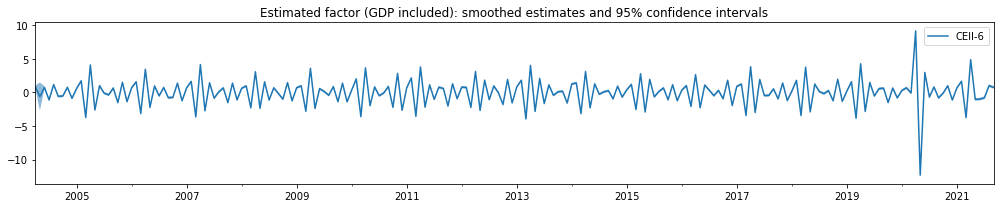

In [82]:
# DFM factor with GDP
ceii_6_factor = dfm(ceii_6, "CEII-6", exog_q= raw_gdp.spliced.diff().diff())

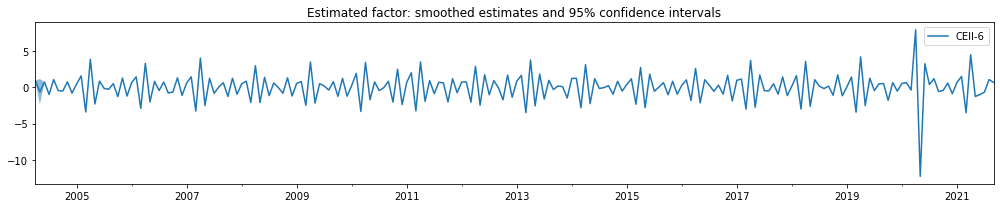

In [83]:
# DFM factor without GDP
ceii_6_factor = dfm(ceii_6,"CEII-6")

As specified in the paper, there does not seem to be any difference in the factor if GDP was included or not

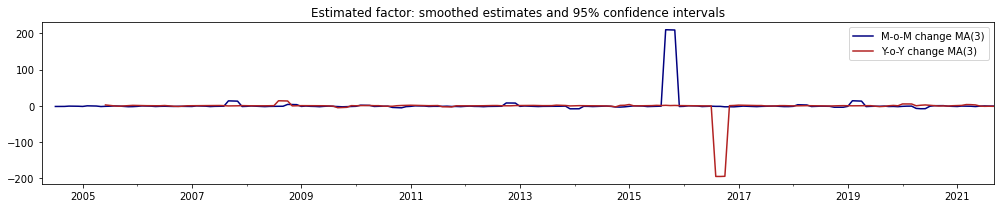

In [84]:
ceii_6_factor = dfm(ceii_6,"CEII-6", ma=True)

### CEII - 9

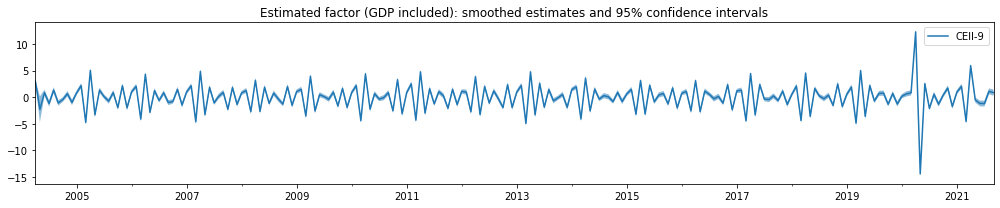

In [144]:
ceii_9_factor = dfm(ceii_9, "CEII-9", exog_q= raw_gdp.spliced.diff().diff())

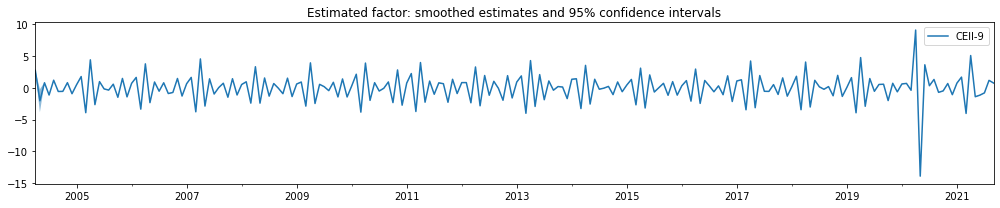

In [145]:
ceii_9_factor = dfm(ceii_9, "CEII-9")

Although tiny there is an increase in the confience interval when we add quarterly GDP into the model 

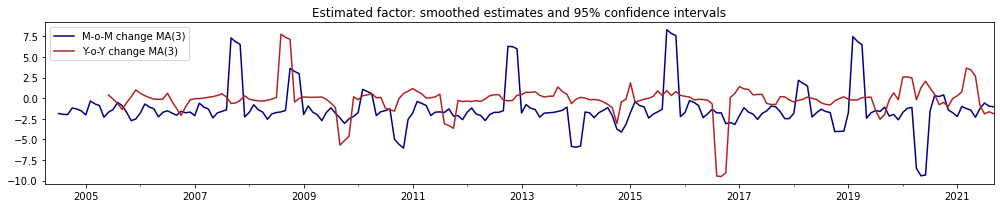

In [146]:
ceii_9_factor = dfm(ceii_9, "CEII-9", ma = True)

### CEII - 12

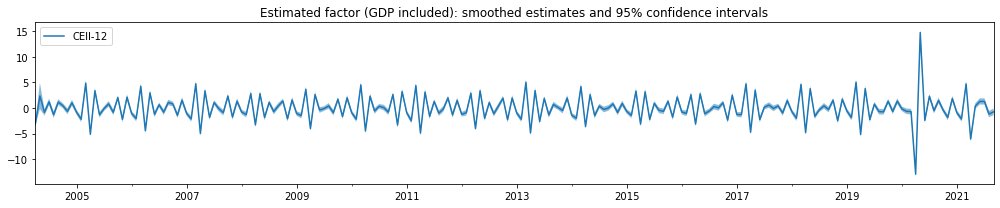

In [115]:
ceii_12_factor = dfm(clean_var, "CEII-12", exog_q= raw_gdp.spliced.diff().diff())

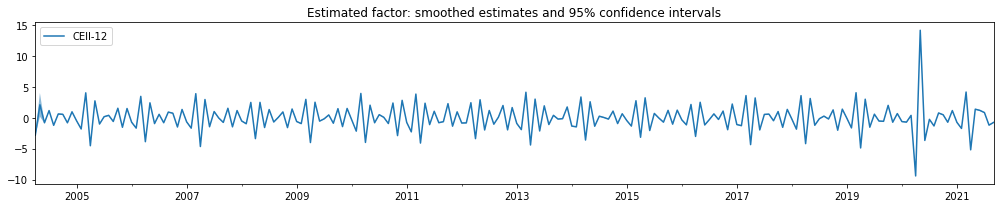

In [114]:
ceii_12_factor = dfm(clean_var, "CEII-12")

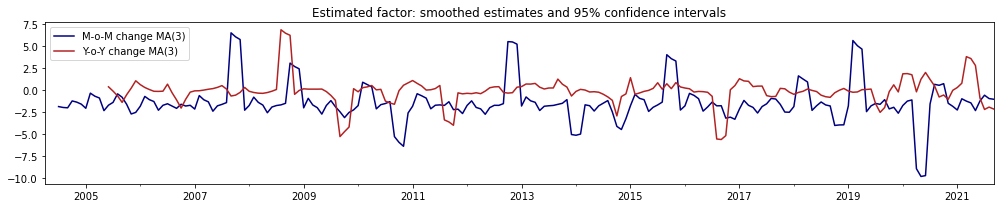

In [116]:
ceii_12_factor = dfm(clean_var, "CEII-12", ma= True)

## Nowcasting GDP

In [249]:
# function to run the regression. Out of sample is 7 Quarters
def regression_model(f, name):
    # resample the factor at the end of the quarter
    quarterly_factor = f.resample("Q").last()
    # calculate yr 0n yr change in the factor and GDP
    y_grate_f = quarterly_factor.pct_change(4)
    y_grate_gdp = raw_gdp.spliced.pct_change(4)
    reg_df = pd.concat([y_grate_gdp, y_grate_f], axis = 1)
    # renaming it beacuse numerical are not accepcted in statsmodels formula
    reg_df = reg_df.rename(columns={name: "factor"})

    # running the regression
    reg_model = smf.ols(formula = "spliced ~ 1 + factor + spliced.shift(1)", data = reg_df.iloc[:-8,:]).fit()

    # prediction dataframe
    pred_data = reg_df.iloc[-9:, :]
    # predicted values
    p = reg_model.predict(exog = pred_data[["factor", "spliced"]])
    # mean sq err
    mse = rmse(reg_df.iloc[-8:-1, :].spliced, p[1:-1])

    return (reg_model, p, mse)

In [250]:
# run the regression
reg_12, pred_12, mse_12 = regression_model(ceii_12_factor, "CEII-12")
reg_9, pred_9, mse_9 = regression_model(ceii_9_factor, "CEII-9")
reg_6, pred_6, mse_6 = regression_model(ceii_6_factor, "CEII-6")

In [255]:
dict_mse = {"model" : ["12 indicator", "9 indicator", "6 indicator"], 
            "mean sq error":[mse_12, mse_9, mse_6]
            }
mse_df = pd.DataFrame(dict_mse, index = [1,2,3])
mse_df

,model,mean sq error
1,12 indicator,0.118206
2,9 indicator,0.118225
3,6 indicator,0.118033


In [260]:
info_dict={'F-statistic' : lambda x: f"{x.fvalue:.3f}",
            'No. observations' : lambda x: f"{int(x.nobs):d}"}

results_table = summary_col(results= [reg_12, reg_9, reg_6],
                            float_format='%0.3f',
                            stars = True,
                            model_names=["12 indicators", "9 indicators", "6 indicators"],
                            info_dict=info_dict,
                            )

results_table.add_title("Nowcasting model estimates: Dep Variable GDP Y-on-Y growth")

# print(results_table.as_latex())
print(results_table)

Nowcasting model estimates: Dep Variable GDP Y-on-Y growth
                 12 indicators 9 indicators 6 indicators
--------------------------------------------------------
Intercept        0.019***      0.019***     0.020***    
                 (0.007)       (0.007)      (0.007)     
factor           -0.002**      -0.002**     -0.002**    
                 (0.001)       (0.001)      (0.001)     
spliced.shift(1) 0.720***      0.720***     0.719***    
                 (0.092)       (0.092)      (0.092)     
R-squared        0.547         0.547        0.546       
R-squared Adj.   0.530         0.531        0.529       
F-statistic      32.628        32.657       32.509      
No. observations 57            57           57          
Standard errors in parentheses.
* p<.1, ** p<.05, ***p<.01


Finally the output that we have been working for:

In [259]:
print(f"Predicted Year-on-Year growth rate og GDP for Q2 2021-22 is {pred_12[-1].round(4)*100}%")

Predicted Year-on-Year growth rate og GDP for Q2 2021-22 is 15.85%
